# Similarity metrics for time series

**File**:    02_clustering_method.ipnv

**Purpose**: First methods to find similar time series for a given target. (There are other possibilities, 
for example, compute statistics of interest for each time series and apply cluster methods [Model based cluster, PCA, and others] to these statistics)

**Authors**: Gabriel R. Palma, Mariusz Skoczeń and Phil Maguire

**Date**:    20/03/24

# Modules used in this project

In [1]:
import numpy as np
from dtaidistance import dtw
from scipy.spatial.distance import euclidean
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Function used in this project

In [2]:
def normalize(ts):
    '''This function normalsies the time series based on their standar deviation and average
    Input:
         ts: A time series
    Ouput:
          ts_normalised: The normalised verion of the time series'''
    
    ts_normalised = (ts - ts.mean()) / ts.std()    
    return ts_normalised

def weighted_similarity(ts1, ts2, weights):
    ''' This function computes a weights similarity score between two time series
    based on the eucledian distance and dynamic time warping distance.
    Inputs:
           ts1: The first time series
           ts2: The second time series
           weights: A simplex vector that indicates the importance of both metrics
    Output:
           similarity_score: A weighted similarity score based on eucledian and dynamic time 
           wraping distances.'''
    # Normalize the time series
    ts1_norm = normalize(ts1)
    ts2_norm = normalize(ts2)
    
    # Calculate Euclidean distance
    euclidean_dist = euclidean(ts1_norm, ts2_norm)
    
    # Calculate DTW distance
    dtw_dist = dtw.distance_fast(ts1_norm, ts2_norm, use_pruning=True)
    
    # Combine the similarity metrics using the provided weights
    similarity = weights['euclidean'] * euclidean_dist + \
                 weights['dtw'] * dtw_dist
    similarity_score = 1 / (1 + similarity)
    
    return similarity_score

def rank_time_series(target_ts, time_series_list, weights):
    ''' This function rank the time series based on the similarity weighted similarity score.
    Inputs:
          target_ts: The target time series that will be used for ranking the other time series;
          time_series_list: A list of time series to be compared with the target time series;
          weights: The weights used to compute the similarity score.
    Ouput:
          ranked_indices: A list of the rank of the time series in respect to the target one.'''
    
    similarities = []
    
    for ts in time_series_list:
        similarity = weighted_similarity(target_ts, ts, weights)
        similarities.append(similarity)
        print(similarity)
    
    # Sort the time series based on their similarity to the target
    ranked_indices = np.argsort(similarities)[::-1]
    
    return ranked_indices

In [3]:
def rank_time_series(target_ts, time_series_list, weights, time_series_names):
    ''' This function ranks the time series based on the weighted similarity score.
    Inputs:
          target_ts: The target time series that will be used for ranking the other time series;
          time_series_list: A list of time series to be compared with the target time series;
          weights: The weights used to compute the similarity score;
          time_series_names: A list of names corresponding to each time series in time_series_list.
    Output:
          ranked_names: A list of the names of the time series ranked with respect to the target one.'''
    
    similarities = []
    
    for ts in time_series_list:
        similarity = weighted_similarity(target_ts, ts, weights)
        similarities.append(similarity)        
    
    # Sort the time series based on their similarity to the target
    ranked_indices = np.argsort(similarities)[::-1]
    
    # Get the names of the ranked time series
    ranked_names = [time_series_names[idx] for idx in ranked_indices]
    similarities_ranked = [similarities[idx] for idx in ranked_indices]
    
    return ranked_names, similarities_ranked

def convert_unix_milliseconds_to_date(unix_milliseconds):
    # Convert milliseconds to seconds
    unix_seconds = unix_milliseconds / 1000.0
    # Create a datetime object from the Unix timestamp
    dt = datetime.fromtimestamp(unix_seconds)
    # Format the datetime object to a string in day/month/year format
    return dt.strftime('%d/%m/%Y')

# Loading datasets

In [4]:
pepe_dataset = pd.read_csv('../output_data/PEPE-USDT.csv', sep=',', header=0, 
                      names=['Date', 'Open', 'High', 'Low', 'Close', 
                             'Volume_contracts', 'Volume_currency', 'Volume_quote', 
                             'Confirmation'])
pepe_dataset = pepe_dataset.iloc[::-1].reset_index(drop=True)
pepe_dataset = pepe_dataset.assign(Date=list(map(lambda x: convert_unix_milliseconds_to_date(x), 
                                        pepe_dataset['Date'])))

In [5]:
pepe_dataset

,Date,Open,High,Low,Close,Volume_contracts,Volume_currency,Volume_quote,Confirmation
0,20/03/2024,0.000007,0.000007,0.000007,0.000007,2.661527e+10,181907.336634,181907.336634,1.0
1,20/03/2024,0.000007,0.000007,0.000007,0.000007,1.093829e+10,74680.616759,74680.616759,1.0
2,20/03/2024,0.000007,0.000007,0.000007,0.000007,9.982869e+09,68176.148644,68176.148644,1.0
3,20/03/2024,0.000007,0.000007,0.000007,0.000007,1.415523e+10,96577.554837,96577.554837,1.0
4,20/03/2024,0.000007,0.000007,0.000007,0.000007,1.527951e+10,104074.556090,104074.556090,1.0
...,...,...,...,...,...,...,...,...,...
3694,22/03/2024,0.000007,0.000007,0.000007,0.000007,1.481465e+10,107540.998780,107540.998780,1.0
3695,22/03/2024,0.000007,0.000007,0.000007,0.000007,1.441718e+10,104537.167621,104537.167621,1.0
3696,22/03/2024,0.000007,0.000007,0.000007,0.000007,1.712711e+10,123430.782428,123430.782428,1.0
3697,22/03/2024,0.000007,0.000007,0.000007,0.000007,1.987515e+10,143118.432639,143118.432639,1.0


In [6]:
crypto_datasets = {}
crypto_names = ['BTC', 'ETH', 'BNB', 'USDC', 'XRP', 'ADA', 'MATIC', 'DOGE', 'SOL', 'DOT', 'SHIB', 'DAI', 'TRX', 'AVAX', 'WBTC', 'LEO', 'LTC', 'ATOM', 'OKB', 'LINK', 'ETC', 'XLM', 'CRO', 'BCH', 'ALGO', 'ICP', 'FIL', 'HBAR', 'FLOW', 'NEAR', 'EGLD', 'APE', 'MANA', 'SAND', 'THETA', 'XTZ', 'AXS', 'EOS', 'AAVE', 'BSV']

for name in crypto_names:
    dataset = pd.read_csv(f'../output_data/{name}-USDT.csv', sep=',', header=0, 
                          names=['Date', 'Open', 'High', 'Low', 'Close', 
                                 'Volume_contracts', 'Volume_currency', 'Volume_quote', 
                                 'Confirmation'])
    dataset = dataset.iloc[::-1].reset_index(drop=True)
    dataset = dataset.assign(Date=list(map(lambda x: convert_unix_milliseconds_to_date(x), 
                                            dataset['Date'])))
    crypto_datasets[name] = dataset

# Case study with cryptocurrencies

In [7]:
# Example usage
target_ts = np.array(pepe_dataset['Close'])
#target_ts = np.array(crypto_datasets['BTC']['Close'])
time_series_list = [dataset['Close'].values for dataset in crypto_datasets.values()]

weights = {
    'euclidean': 1,
    'dtw': 0
}
time_series_names = ['BTC', 'ETH', 'BNB', 'USDC', 'XRP', 'ADA', 'MATIC', 'DOGE', 'SOL', 'DOT', 'SHIB', 'DAI', 'TRX', 'AVAX', 'WBTC', 'LEO', 'LTC', 'ATOM', 'OKB', 'LINK', 'ETC', 'XLM', 'CRO', 'BCH', 'ALGO', 'ICP', 'FIL', 'HBAR', 'FLOW', 'NEAR', 'EGLD', 'APE', 'MANA', 'SAND', 'THETA', 'XTZ', 'AXS', 'EOS', 'AAVE', 'BSV']
ranked_indices, similarities = rank_time_series(target_ts, time_series_list, weights, time_series_names)
print("Ranking of time series based on Pepe time series:")
for i, idx in enumerate(ranked_indices, start=1):
    print(f"{i}. {idx} Time Series (Similarity = {similarities[i-1]})")

Ranking of time series based on Pepe time series:
1. WBTC Time Series (Similarity = 0.048545183907723895)
2. BTC Time Series (Similarity = 0.04798662238191784)
3. ETH Time Series (Similarity = 0.04773460964498998)
4. FLOW Time Series (Similarity = 0.04488259876390418)
5. CRO Time Series (Similarity = 0.044535617272115344)
6. ETC Time Series (Similarity = 0.0444044951399999)
7. BSV Time Series (Similarity = 0.0437298246688903)
8. XTZ Time Series (Similarity = 0.04277227813117145)
9. EGLD Time Series (Similarity = 0.042109877481056074)
10. ALGO Time Series (Similarity = 0.04000166881344166)
11. ADA Time Series (Similarity = 0.039965254264609125)
12. HBAR Time Series (Similarity = 0.03954773814254542)
13. ATOM Time Series (Similarity = 0.0389941865012204)
14. OKB Time Series (Similarity = 0.03870021120586193)
15. MANA Time Series (Similarity = 0.03857315723114076)
16. APE Time Series (Similarity = 0.0369554547182347)
17. EOS Time Series (Similarity = 0.03661877636083167)
18. THETA Time Se

In [8]:
differences = np.mean((np.array(normalize(pepe_dataset['Close']) - normalize(crypto_datasets['WBTC']['Close'])), 
         np.array(normalize(pepe_dataset['Close']) - normalize(crypto_datasets['BTC']['Close'])),
         np.array(normalize(pepe_dataset['Close']) - normalize(crypto_datasets['ETH']['Close'])), 
         np.array(normalize(pepe_dataset['Close']) - normalize(crypto_datasets['FLOW']['Close'])), 
         np.array(normalize(pepe_dataset['Close']) - normalize(crypto_datasets['FLOW']['Close']))              
        
        ) 
        
        , axis=0)

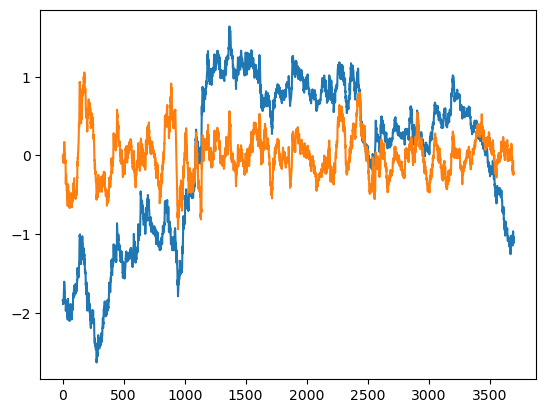

In [9]:
plt.plot(normalize(pepe_dataset['Close']))
plt.plot(differences)
plt.show()

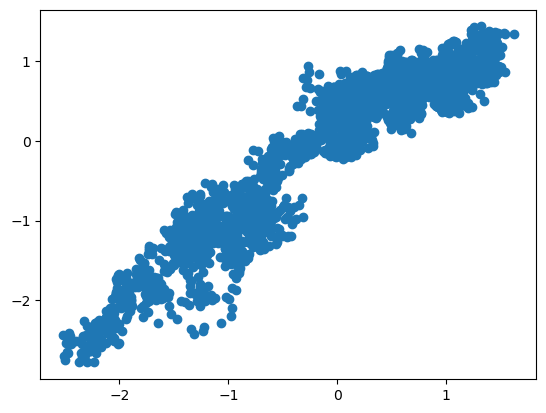

In [10]:
plt.scatter(normalize(crypto_datasets['BTC']['Close']), 
           normalize(crypto_datasets['FLOW']['Close']))

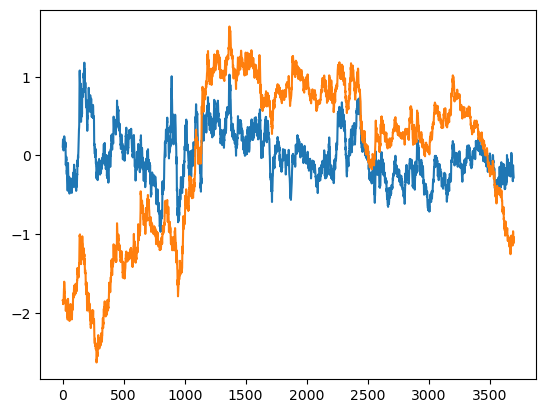

In [11]:
plt.plot(normalize(target_ts)-
         normalize(crypto_datasets['ETH']['Close']))
plt.plot(normalize(target_ts))

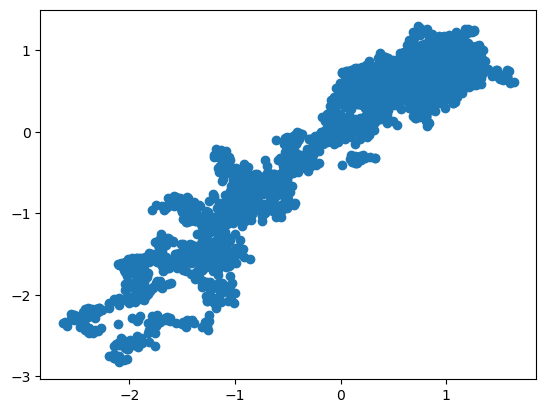

In [13]:
plt.scatter(normalize(target_ts),
         normalize(crypto_datasets['ETH']['Close']))

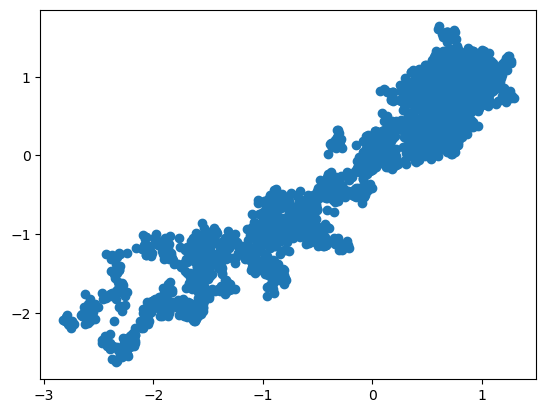

In [14]:
plt.scatter(normalize(crypto_datasets['ETH']['Close']), 
           normalize(target_ts))

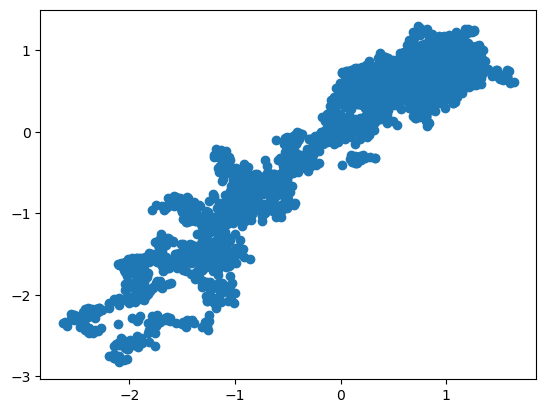

In [15]:
plt.scatter(normalize(target_ts), 
            normalize(crypto_datasets['ETH']['Close']))

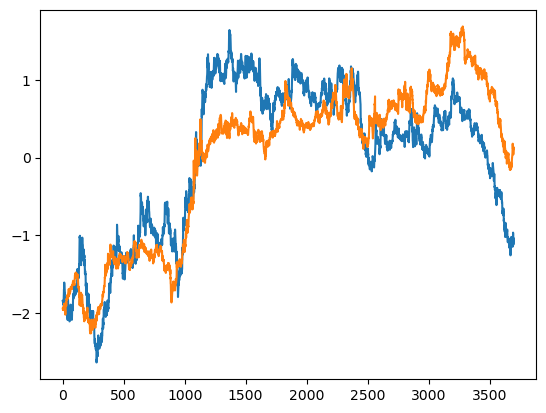

In [16]:
plt.plot(normalize(target_ts))
plt.plot(normalize(crypto_datasets['DOGE']['Close']))

In [17]:
weights = {
    'euclidean': 0,
    'dtw': 1
}
time_series_names = ['BTC', 'ETH', 'BNB', 'USDC', 'XRP', 'ADA', 'MATIC', 'DOGE', 'SOL', 'DOT', 'SHIB', 'DAI', 'TRX', 'AVAX', 'WBTC', 'LEO', 'LTC', 'ATOM', 'OKB', 'LINK', 'ETC', 'XLM', 'CRO', 'BCH', 'ALGO', 'ICP', 'FIL', 'HBAR', 'FLOW', 'NEAR', 'EGLD', 'APE', 'MANA', 'SAND', 'THETA', 'XTZ', 'AXS', 'EOS', 'AAVE', 'BSV']
ranked_indices, similarities = rank_time_series(target_ts, time_series_list, weights, time_series_names)
print("Ranking of time series based on Pepe time series:")
for i, idx in enumerate(ranked_indices, start=1):
    print(f"{i}. {idx} Time Series (Similarity = {similarities[i-1]})")

Ranking of time series based on Pepe time series:
1. BTC Time Series (Similarity = 0.1884659067266641)
2. FLOW Time Series (Similarity = 0.17503186295033968)
3. ETC Time Series (Similarity = 0.1687834389067876)
4. ALGO Time Series (Similarity = 0.163359795097098)
5. EGLD Time Series (Similarity = 0.16080087757217193)
6. WBTC Time Series (Similarity = 0.15499359878066413)
7. ETH Time Series (Similarity = 0.15422582503125334)
8. BSV Time Series (Similarity = 0.1534677443429659)
9. XTZ Time Series (Similarity = 0.14802477505926248)
10. HBAR Time Series (Similarity = 0.1473896965687051)
11. ATOM Time Series (Similarity = 0.13612676922717457)
12. APE Time Series (Similarity = 0.13186350166700406)
13. ADA Time Series (Similarity = 0.12805338767279792)
14. LTC Time Series (Similarity = 0.1273241087297307)
15. CRO Time Series (Similarity = 0.1232753802153059)
16. LINK Time Series (Similarity = 0.1209424838459616)
17. OKB Time Series (Similarity = 0.11826160005603223)
18. EOS Time Series (Simil

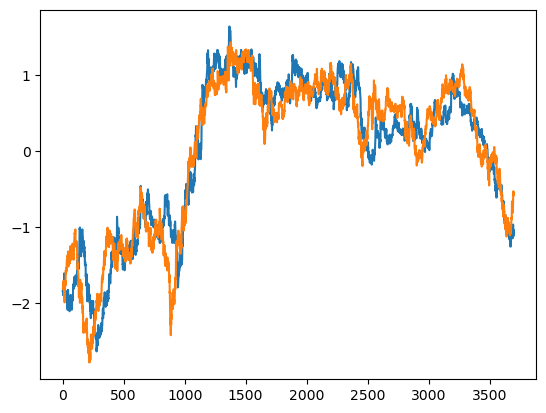

In [18]:
plt.plot(normalize(target_ts))
plt.plot(normalize(crypto_datasets['FLOW']['Close']))

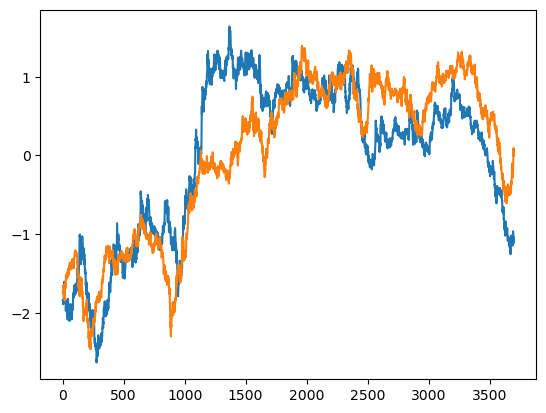

In [19]:
plt.plot(normalize(target_ts))
plt.plot(normalize(crypto_datasets['FIL']['Close']))